TensorFlow version: 2.15.0
GPU available: False
Running on CPU

Experiment: seq90_regression_macd
Save to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_regression_macd
Data loaded: (2516, 16)
   Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00

FEATURE SELECTION

Selected features: 8
   0: Close
   1: Volume
   2: MA7
   3: MA30
   4: Volatility
   5: RSI
   6: HL_Spread
   7: Return

Clean dataset shape: (2486, 8)

Target 'Close' is at index 0

TRAIN/VALIDATION/TEST SPLIT

Split:
   Train:      1740 days (2015-02-17 to 2022-01-11)
   Validation: 372 days (2022-01-12 to 2023-07-07)
   Test:       374 days (2023-07-10 to 2024-12-31)
   Ratio:      70% / 15% / 15%

Important: No shuffling! Time order preserved.

DATA SCALING

Data scaled to range [0, 1]
   Train scaled shape: (1740, 8)
   Val scaled shape:   (372, 8)
   Test scaled shape:  (374, 8)

CRITICAL: Scaler was FIT only on training data!
   This prevents data leakage from validation/test sets.

Scal

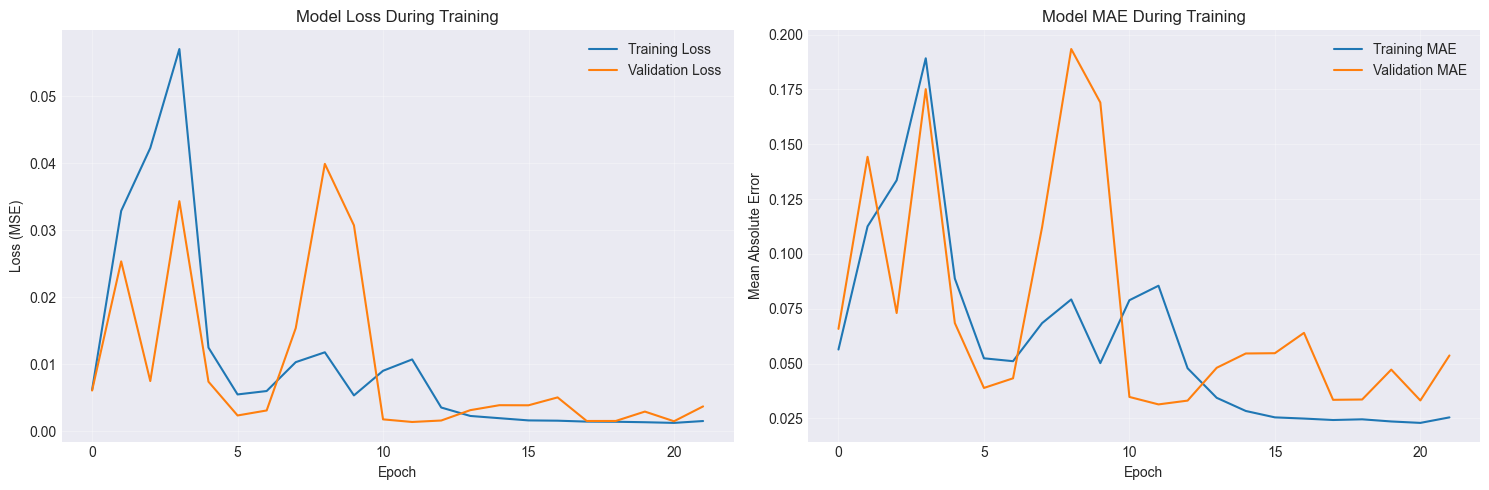


EVALUATE ON TEST SET

Making predictions on test set...

Inverse transforming predictions...
Inverse transform complete!

Calculating metrics...

Test Set Performance:
   MSE:  391.3843
   RMSE: $19.78
   MAE:  $16.34
   MAPE: 7.49%
   Directional Accuracy: 56.54%

Visualizing predictions...


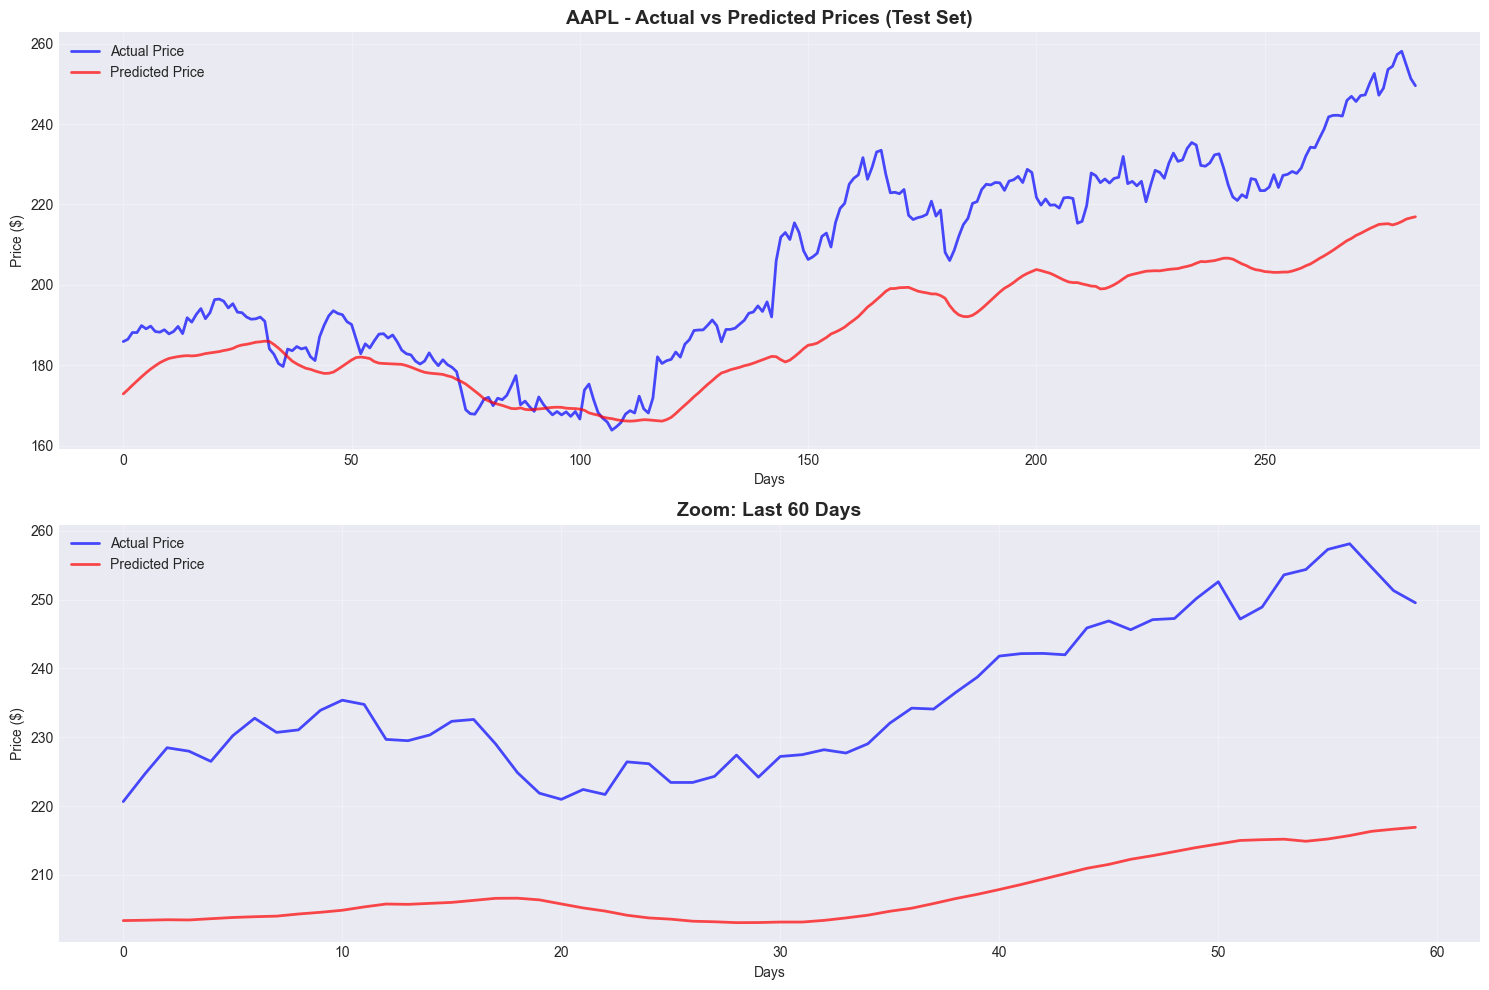

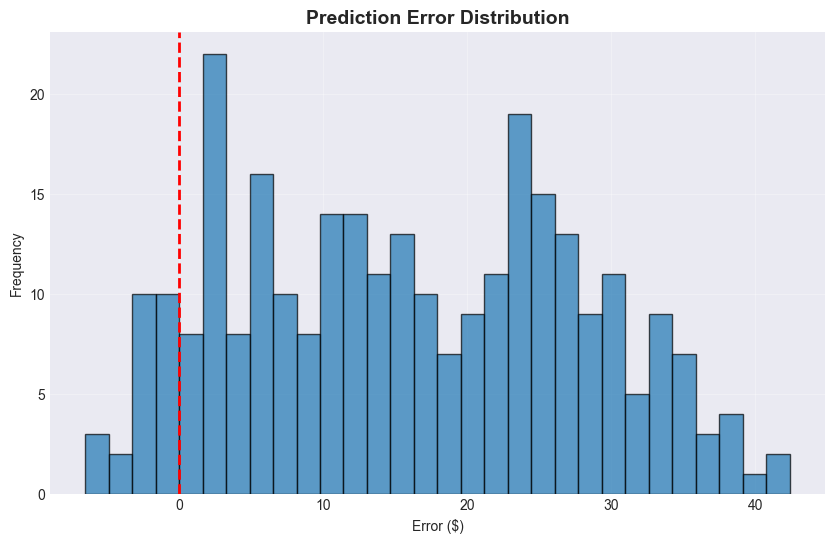


Error Statistics:
   Mean Error: $15.95
   Std Error:  $11.70

SAVING MODEL
INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_regression_macd\model\assets


INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_regression_macd\model\assets



Model saved: ..\models\saved_models\AAPL_lstm_model
Training history saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_training_history.pkl
Model info saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_model_info.pkl

PHASE 2 COMPLETE!

Summary:
   Ticker: AAPL
   Model: LSTM with 33,301 parameters
   Sequence length: 90 days
   Training samples: 1650
   Test RMSE: $19.78
   Test MAPE: 7.49%
   Directional Accuracy: 56.54%

Saved files:
   Model: ..\models\saved_models\AAPL_lstm_model
   Scaler: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_scaler.pkl
   History: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_training_history.pkl
   Info: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_model_info.pkl

Experiment logged to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\experiments_log.csv

To load this model later:
   model = keras.models.load_model('..\models\saved_models\AAPL_lstm_model

In [4]:
"""
StockVision — Phase 2: LSTM Model Training (IMPROVED)
======================================================
Verbesserte Version mit:
- Expliziter Validation Split für Zeitreihen
- Robuster Inverse Transform
- TimeSeriesSplit ready
- Bessere Metriken
"""

# ==========================================
# Imports
# ==========================================
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpu_devices) > 0}")
if len(gpu_devices) > 0:
    print(f"   GPU: {gpu_devices}")
else:
    print("Running on CPU")
# ==========================================
# Path
# ==========================================

BASE_DIR = Path.cwd().parent
MODELS_DIR = BASE_DIR / "models"
CHECKPOINTS_DIR = MODELS_DIR / "checkpoints"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)


# ==========================================
# Experiment Configuration
# ==========================================

EXPERIMENT_NAME = "seq90_regression_macd" 

ticker = "AAPL"
SEQUENCE_LENGTH = 90

# Paths für dieses Experiment
EXPERIMENT_DIR = MODELS_DIR / f"{ticker}_{EXPERIMENT_NAME}"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_SAVE_PATH = EXPERIMENT_DIR / "model"
CHECKPOINT_PATH = CHECKPOINTS_DIR / f"{ticker}_{EXPERIMENT_NAME}_best.keras"
SCALER_PATH = EXPERIMENT_DIR / "scaler.pkl"
HISTORY_PATH = EXPERIMENT_DIR / "training_history.pkl"
INFO_PATH = EXPERIMENT_DIR / "model_info.pkl"

print(f"\nExperiment: {EXPERIMENT_NAME}")
print(f"Save to: {EXPERIMENT_DIR}")    

# ==========================================
# Load Data
# ==========================================

data_path = DATA_PROCESSED / f"{ticker}_features.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"Data loaded: {df.shape}")
print(f"   Date range: {df.index[0]} to {df.index[-1]}")

# ==========================================
# Feature Selection
# ==========================================

print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

feature_columns = [
    'Close',
    'Volume',
    'MA7',
    'MA30',
    'Volatility',
    'RSI',
    'HL_Spread',
    'Return'
]

target_column = 'Close'

# Remove NaN
df_clean = df[feature_columns].dropna()

print(f"\nSelected features: {len(feature_columns)}")
for i, feat in enumerate(feature_columns):
    print(f"   {i}: {feat}")

print(f"\nClean dataset shape: {df_clean.shape}")

# Store target index for later inverse transform
target_idx = feature_columns.index(target_column)
print(f"\nTarget '{target_column}' is at index {target_idx}")

# ==========================================
# Train/Val/Test Split (TEMPORAL!)
# ==========================================

print("\n" + "="*60)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*60)

# Split: 70% train, 15% validation, 15% test
train_size = int(len(df_clean) * 0.70)
val_size = int(len(df_clean) * 0.15)

train_data = df_clean.iloc[:train_size]
val_data = df_clean.iloc[train_size:train_size + val_size]
test_data = df_clean.iloc[train_size + val_size:]

print(f"\nSplit:")
print(f"   Train:      {len(train_data)} days ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"   Validation: {len(val_data)} days ({val_data.index[0].date()} to {val_data.index[-1].date()})")
print(f"   Test:       {len(test_data)} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")
print(f"   Ratio:      {len(train_data)/len(df_clean)*100:.0f}% / {len(val_data)/len(df_clean)*100:.0f}% / {len(test_data)/len(df_clean)*100:.0f}%")

print("\nImportant: No shuffling! Time order preserved.")

# ==========================================
# Data Scaling (FIT ONLY ON TRAIN!)
# ==========================================

print("\n" + "="*60)
print("DATA SCALING")
print("="*60)

# CRITICAL: Fit scaler ONLY on training data!
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)  # fit_transform on train
val_scaled = scaler.transform(val_data)          # transform only (no fit!)
test_scaled = scaler.transform(test_data)        # transform only (no fit!)

print(f"\nData scaled to range [0, 1]")
print(f"   Train scaled shape: {train_scaled.shape}")
print(f"   Val scaled shape:   {val_scaled.shape}")
print(f"   Test scaled shape:  {test_scaled.shape}")

print("\nCRITICAL: Scaler was FIT only on training data!")
print("   This prevents data leakage from validation/test sets.")

# Save scaler
scaler_path = MODELS_DIR / f"{ticker}_scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\nScaler saved: {scaler_path}")

# ==========================================
# Create Sequences for LSTM
# ==========================================

print("\n" + "="*60)
print("CREATING LSTM SEQUENCES")
print("="*60)

def create_sequences(data, sequence_length, target_idx=0):
    """
    Create sequences for LSTM.
    
    Args:
        data: Scaled numpy array (n_samples, n_features)
        sequence_length: Number of time steps to look back
        target_idx: Index of target column (default 0 for 'Close')
    
    Returns:
        X: (n_samples, sequence_length, n_features)
        y: (n_samples,) - target values
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Last 'sequence_length' days
        y.append(data[i, target_idx])        # Target at index 'target_idx'
    
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 90  #test 30, 60, 90

print(f"\nCreating sequences with length: {SEQUENCE_LENGTH} days")
print(f"   Target column: '{target_column}' (index {target_idx})")

X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH, target_idx)
X_val, y_val = create_sequences(val_scaled, SEQUENCE_LENGTH, target_idx)
X_test, y_test = create_sequences(test_scaled, SEQUENCE_LENGTH, target_idx)

print(f"\nSequences created:")
print(f"   X_train: {X_train.shape} (samples, timesteps, features)")
print(f"   y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")

# ==========================================
# Build LSTM Model
# ==========================================

print("\n" + "="*60)
print("BUILDING LSTM MODEL")
print("="*60)

def build_lstm_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(50, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        layers.Dropout(0.2, name='dropout_1'),
        
        layers.LSTM(50, return_sequences=False, name='lstm_2'),
        layers.Dropout(0.2, name='dropout_2'),
        
        layers.Dense(25, activation='relu', name='dense_1'),
        layers.Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

print("\nModel Architecture:")
model.summary()

# ==========================================
# Setup Callbacks
# ==========================================

print("\n" + "="*60)
print("SETUP TRAINING CALLBACKS")
print("="*60)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(CHECKPOINT_PATH),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

print("Callbacks configured")

# ==========================================
# Train Model
# ==========================================

print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

EPOCHS = 50
BATCH_SIZE = 32

print(f"\nTraining configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Validation: Explicit validation set (not split from train)")
print(f"   Shuffle: False (time series!)")

print("\nStarting training...\n")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),  # Explicit validation set!
    callbacks=callbacks,
    shuffle=False,  # CRITICAL: Don't shuffle time series!
    verbose=1
)

print("\nTraining complete!")

# ==========================================
# Training History Visualization
# ==========================================

print("\nPlotting training history...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss During Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE During Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# Evaluate on Test Set
# ==========================================

print("\n" + "="*60)
print("EVALUATE ON TEST SET")
print("="*60)

print("\nMaking predictions on test set...")
y_pred_scaled = model.predict(X_test, verbose=0).flatten()

# ==========================================
# Inverse Transform (ROBUST METHOD!)
# ==========================================

print("\nInverse transforming predictions...")

def inverse_transform_predictions(y_scaled, scaler, target_idx, n_features):
    """
    Robustly inverse transform predictions.
    
    The scaler expects (n_samples, n_features), but we only have
    the target column. Solution: Create zeros array and fill target column.
    
    Args:
        y_scaled: Scaled predictions (1D array)
        scaler: Fitted MinMaxScaler
        target_idx: Index of target column
        n_features: Total number of features
    
    Returns:
        y_actual: Inverse transformed values
    """
    n_samples = len(y_scaled)
    
    # Create full-feature array filled with zeros
    y_full = np.zeros((n_samples, n_features))
    
    # Fill target column with our predictions
    y_full[:, target_idx] = y_scaled
    
    # Inverse transform
    y_full_inv = scaler.inverse_transform(y_full)
    
    # Extract only target column
    return y_full_inv[:, target_idx]

n_features = len(feature_columns)

# Inverse transform predictions
y_pred = inverse_transform_predictions(y_pred_scaled, scaler, target_idx, n_features)

# Inverse transform actual values
y_test_actual = inverse_transform_predictions(y_test, scaler, target_idx, n_features)

print("Inverse transform complete!")

# ==========================================
# Calculate Metrics
# ==========================================

print("\nCalculating metrics...")

# MSE & RMSE
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test_actual, y_pred)

# MAPE (handle division by zero)
mape = np.mean(np.abs((y_test_actual - y_pred) / np.where(y_test_actual != 0, y_test_actual, 1))) * 100

# Directional Accuracy (did we predict direction correctly?)
actual_direction = np.diff(y_test_actual) > 0
pred_direction = np.diff(y_pred) > 0
directional_accuracy = np.mean(actual_direction == pred_direction) * 100

print(f"\nTest Set Performance:")
print(f"   MSE:  {mse:.4f}")
print(f"   RMSE: ${rmse:.2f}")
print(f"   MAE:  ${mae:.2f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   Directional Accuracy: {directional_accuracy:.2f}%")

# ==========================================
# Visualize Predictions
# ==========================================

print("\nVisualizing predictions...")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full test period
axes[0].plot(y_test_actual, label='Actual Price', linewidth=2, alpha=0.7, color='blue')
axes[0].plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.7, color='red')
axes[0].set_title(f'{ticker} - Actual vs Predicted Prices (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Last 60 days (zoom in)
zoom_days = 60
axes[1].plot(y_test_actual[-zoom_days:], label='Actual Price', linewidth=2, alpha=0.7, color='blue')
axes[1].plot(y_pred[-zoom_days:], label='Predicted Price', linewidth=2, alpha=0.7, color='red')
axes[1].set_title(f'Zoom: Last {zoom_days} Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error distribution
residuals = y_test_actual - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nError Statistics:")
print(f"   Mean Error: ${np.mean(residuals):.2f}")
print(f"   Std Error:  ${np.std(residuals):.2f}")

# ==========================================
# Save Final Model
# ==========================================

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save as SavedModel format (more stable than .h5)
model.save(MODEL_SAVE_PATH)
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)
with open(INFO_PATH, 'wb') as f:
    pickle.dump(model_info, f)

print(f"\nModel saved: {model_path}")

# Save training history
history_path = MODELS_DIR / f"{ticker}_training_history.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved: {history_path}")

# Save model info
model_info = {
    'ticker': ticker,
    'sequence_length': SEQUENCE_LENGTH,
    'features': feature_columns,
    'target_idx': target_idx,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'mape': float(mape),
    'directional_accuracy': float(directional_accuracy),
    'epochs_trained': len(history.history['loss']),
    'n_features': n_features,
    'experiment_dir': str(EXPERIMENT_DIR),
    'checkpoint_path': str(CHECKPOINT_PATH)
}

info_path = MODELS_DIR / f"{ticker}_model_info.pkl"
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Model info saved: {info_path}")

# ==========================================
# Summary
# ==========================================

print("\n" + "="*60)
print("PHASE 2 COMPLETE!")
print("="*60)

print(f"\nSummary:")
print(f"   Ticker: {ticker}")
print(f"   Model: LSTM with {model.count_params():,} parameters")
print(f"   Sequence length: {SEQUENCE_LENGTH} days")
print(f"   Training samples: {len(X_train)}")
print(f"   Test RMSE: ${rmse:.2f}")
print(f"   Test MAPE: {mape:.2f}%")
print(f"   Directional Accuracy: {directional_accuracy:.2f}%")

print(f"\nSaved files:")
print(f"   Model: {model_path}")
print(f"   Scaler: {scaler_path}")
print(f"   History: {history_path}")
print(f"   Info: {info_path}")

# ==========================================
# Log Experiment Results
# ==========================================

experiments_log_path = MODELS_DIR / "experiments_log.csv"

# Experiment data
experiment_data = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'experiment_name': EXPERIMENT_NAME,
    'ticker': ticker,
    'sequence_length': SEQUENCE_LENGTH,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(feature_columns),
    'epochs_trained': len(history.history['loss']),
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'mape': float(mape),
    'directional_accuracy': float(directional_accuracy),
    'model_params': model.count_params(),
    'notes': 'Baseline'  # ← Eigene Notizen!
}

# Load or create log
if experiments_log_path.exists():
    log_df = pd.read_csv(experiments_log_path)
else:
    log_df = pd.DataFrame()

# Append new experiment
log_df = pd.concat([log_df, pd.DataFrame([experiment_data])], ignore_index=True)

# Save
log_df.to_csv(experiments_log_path, index=False)

print(f"\nExperiment logged to: {experiments_log_path}")

print(f"\nTo load this model later:")
print(f"   model = keras.models.load_model('{model_path}')")
print(f"   with open('{scaler_path}', 'rb') as f:")
print(f"       scaler = pickle.load(f)")


TensorFlow version: 2.15.0
GPU available: False
Running on CPU

Experiment: seq90_macd_features
Save to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_macd_features
Data loaded: (2516, 21)
   Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00

FEATURE SELECTION

Selected features: 6
   0: Close
   1: MACD
   2: MACD_Signal
   3: BB_Upper
   4: BB_Lower
   5: ATR

Clean dataset shape: (2497, 6)

Target 'Close' is at index 0

TRAIN/VALIDATION/TEST SPLIT

Split:
   Train:      1747 days (2015-01-30 to 2022-01-05)
   Validation: 374 days (2022-01-06 to 2023-07-05)
   Test:       376 days (2023-07-06 to 2024-12-31)
   Ratio:      70% / 15% / 15%

Important: No shuffling! Time order preserved.

DATA SCALING

Data scaled to range [0, 1]
   Train scaled shape: (1747, 6)
   Val scaled shape:   (374, 6)
   Test scaled shape:  (376, 6)

CRITICAL: Scaler was FIT only on training data!
   This prevents data leakage from validation/test sets.

Scaler saved: C:\Users\jamin\

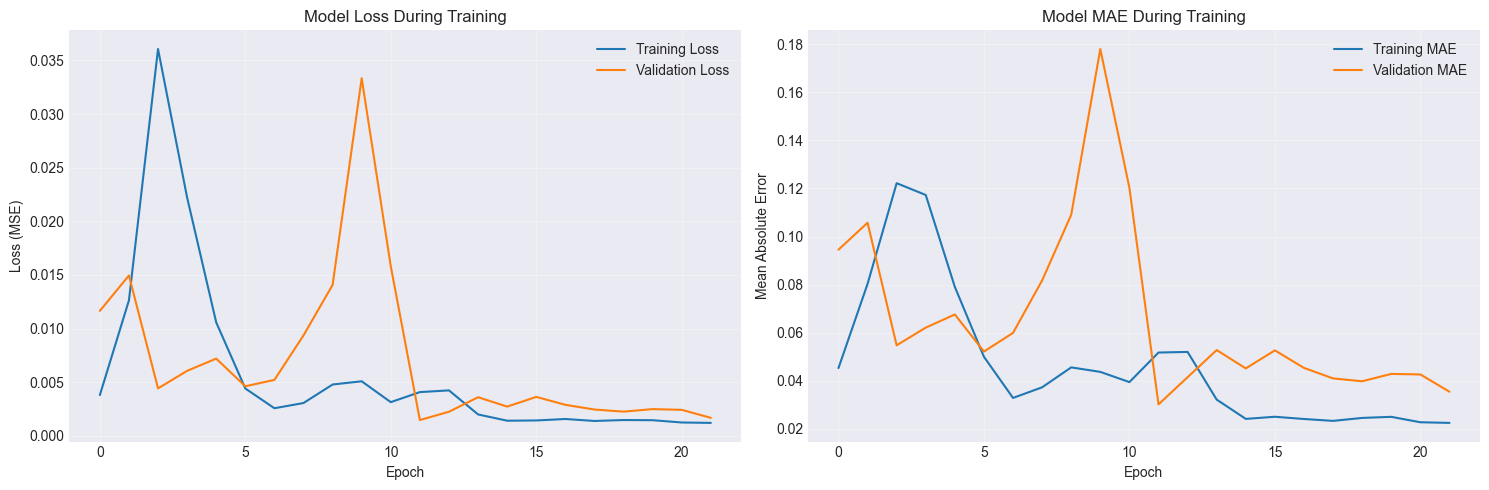


EVALUATE ON TEST SET

Making predictions on test set...

Inverse transforming predictions...
Inverse transform complete!

Calculating metrics...

Test Set Performance:
   MSE:  65.7999
   RMSE: $8.11
   MAE:  $6.63
   MAPE: 3.29%
   Directional Accuracy: 53.68%

Visualizing predictions...


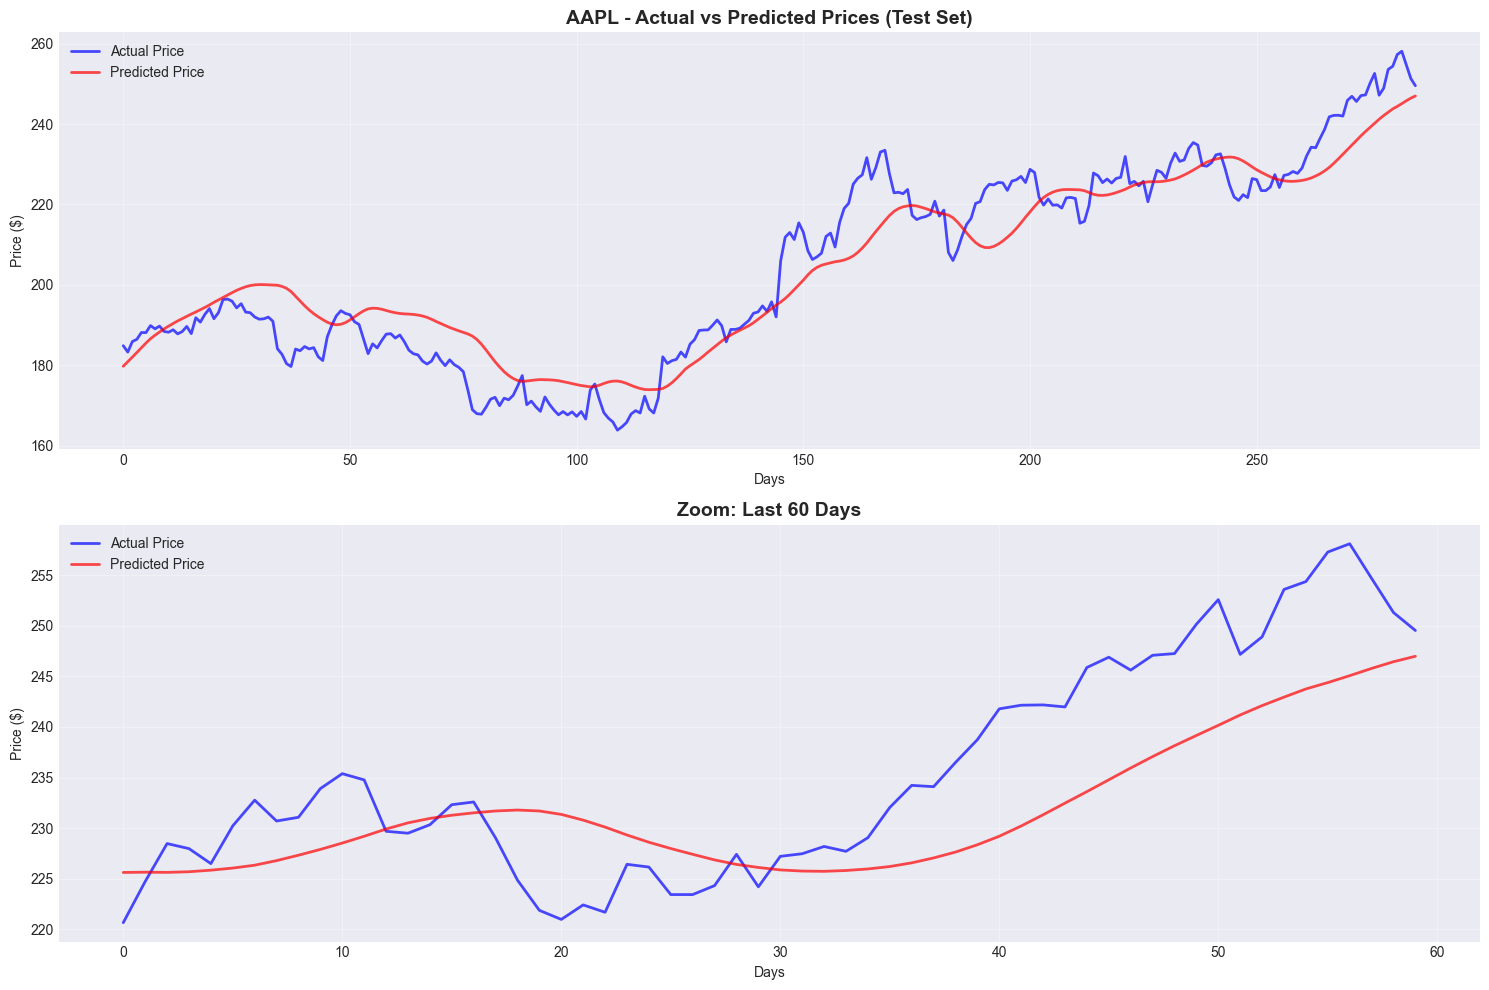

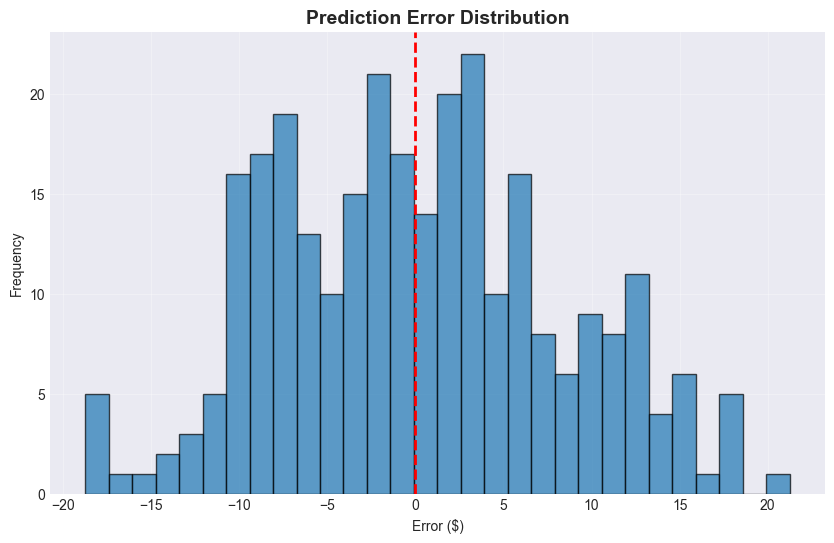


Error Statistics:
   Mean Error: $0.10
   Std Error:  $8.11

SAVING MODEL
INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_macd_features\model\assets


INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq90_macd_features\model\assets



Model saved: ..\models\saved_models\AAPL_lstm_model
Training history saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_training_history.pkl
Model info saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_model_info.pkl

PHASE 2 COMPLETE!

Summary:
   Ticker: AAPL
   Model: LSTM with 32,901 parameters
   Sequence length: 90 days
   Training samples: 1657
   Test RMSE: $8.11
   Test MAPE: 3.29%
   Directional Accuracy: 53.68%

Saved files:
   Model: ..\models\saved_models\AAPL_lstm_model
   Scaler: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_scaler.pkl
   History: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_training_history.pkl
   Info: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_model_info.pkl

Experiment logged to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\experiments_log.csv

To load this model later:
   model = keras.models.load_model('..\models\saved_models\AAPL_lstm_model'

In [5]:
"""
StockVision — Phase 2: LSTM Model Training (seq90_macd_features)
======================================================
Verbesserte Version mit:
- Expliziter Validation Split für Zeitreihen
- Robuster Inverse Transform
- TimeSeriesSplit ready
- Bessere Metriken
"""

# ==========================================
# Imports
# ==========================================
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpu_devices) > 0}")
if len(gpu_devices) > 0:
    print(f"   GPU: {gpu_devices}")
else:
    print("Running on CPU")
# ==========================================
# Path
# ==========================================

BASE_DIR = Path.cwd().parent
MODELS_DIR = BASE_DIR / "models"
CHECKPOINTS_DIR = MODELS_DIR / "checkpoints"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)


# ==========================================
# Experiment Configuration
# ==========================================

EXPERIMENT_NAME = "seq90_macd_features" 

ticker = "AAPL"
SEQUENCE_LENGTH = 90

# Paths für dieses Experiment
EXPERIMENT_DIR = MODELS_DIR / f"{ticker}_{EXPERIMENT_NAME}"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_SAVE_PATH = EXPERIMENT_DIR / "model"
CHECKPOINT_PATH = CHECKPOINTS_DIR / f"{ticker}_{EXPERIMENT_NAME}_best.keras"
SCALER_PATH = EXPERIMENT_DIR / "scaler.pkl"
HISTORY_PATH = EXPERIMENT_DIR / "training_history.pkl"
INFO_PATH = EXPERIMENT_DIR / "model_info.pkl"

print(f"\nExperiment: {EXPERIMENT_NAME}")
print(f"Save to: {EXPERIMENT_DIR}")    

# ==========================================
# Load Data
# ==========================================

data_path = DATA_PROCESSED / f"{ticker}_features.csv"
df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"Data loaded: {df.shape}")
print(f"   Date range: {df.index[0]} to {df.index[-1]}")

# ==========================================
# Feature Selection
# ==========================================

print("\n" + "="*60)
print("FEATURE SELECTION")
print("="*60)

feature_columns = [
    'Close',        # main target feature
    'MACD',         # trend strength
    'MACD_Signal',  # signal line
    'BB_Upper',     # upper Bollinger band
    'BB_Lower',     # lower Bollinger band
    'ATR'           # volatility
]


target_column = 'Close'

# Remove NaN
df_clean = df[feature_columns].dropna()

print(f"\nSelected features: {len(feature_columns)}")
for i, feat in enumerate(feature_columns):
    print(f"   {i}: {feat}")

print(f"\nClean dataset shape: {df_clean.shape}")

# Store target index for later inverse transform
target_idx = feature_columns.index(target_column)
print(f"\nTarget '{target_column}' is at index {target_idx}")

# ==========================================
# Train/Val/Test Split (TEMPORAL!)
# ==========================================

print("\n" + "="*60)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*60)

# Split: 70% train, 15% validation, 15% test
train_size = int(len(df_clean) * 0.70)
val_size = int(len(df_clean) * 0.15)

train_data = df_clean.iloc[:train_size]
val_data = df_clean.iloc[train_size:train_size + val_size]
test_data = df_clean.iloc[train_size + val_size:]

print(f"\nSplit:")
print(f"   Train:      {len(train_data)} days ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"   Validation: {len(val_data)} days ({val_data.index[0].date()} to {val_data.index[-1].date()})")
print(f"   Test:       {len(test_data)} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")
print(f"   Ratio:      {len(train_data)/len(df_clean)*100:.0f}% / {len(val_data)/len(df_clean)*100:.0f}% / {len(test_data)/len(df_clean)*100:.0f}%")

print("\nImportant: No shuffling! Time order preserved.")

# ==========================================
# Data Scaling (FIT ONLY ON TRAIN!)
# ==========================================

print("\n" + "="*60)
print("DATA SCALING")
print("="*60)

# CRITICAL: Fit scaler ONLY on training data!
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)  # fit_transform on train
val_scaled = scaler.transform(val_data)          # transform only (no fit!)
test_scaled = scaler.transform(test_data)        # transform only (no fit!)

print(f"\nData scaled to range [0, 1]")
print(f"   Train scaled shape: {train_scaled.shape}")
print(f"   Val scaled shape:   {val_scaled.shape}")
print(f"   Test scaled shape:  {test_scaled.shape}")

print("\nCRITICAL: Scaler was FIT only on training data!")
print("   This prevents data leakage from validation/test sets.")

# Save scaler
scaler_path = MODELS_DIR / f"{ticker}_scaler.pkl"
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\nScaler saved: {scaler_path}")

# ==========================================
# Create Sequences for LSTM
# ==========================================

print("\n" + "="*60)
print("CREATING LSTM SEQUENCES")
print("="*60)

def create_sequences(data, sequence_length, target_idx=0):
    """
    Create sequences for LSTM.
    
    Args:
        data: Scaled numpy array (n_samples, n_features)
        sequence_length: Number of time steps to look back
        target_idx: Index of target column (default 0 for 'Close')
    
    Returns:
        X: (n_samples, sequence_length, n_features)
        y: (n_samples,) - target values
    """
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Last 'sequence_length' days
        y.append(data[i, target_idx])        # Target at index 'target_idx'
    
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 90  #test 30, 60, 90

print(f"\nCreating sequences with length: {SEQUENCE_LENGTH} days")
print(f"   Target column: '{target_column}' (index {target_idx})")

X_train, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH, target_idx)
X_val, y_val = create_sequences(val_scaled, SEQUENCE_LENGTH, target_idx)
X_test, y_test = create_sequences(test_scaled, SEQUENCE_LENGTH, target_idx)

print(f"\nSequences created:")
print(f"   X_train: {X_train.shape} (samples, timesteps, features)")
print(f"   y_train: {y_train.shape}")
print(f"   X_val:   {X_val.shape}")
print(f"   y_val:   {y_val.shape}")
print(f"   X_test:  {X_test.shape}")
print(f"   y_test:  {y_test.shape}")

# ==========================================
# Build LSTM Model
# ==========================================

print("\n" + "="*60)
print("BUILDING LSTM MODEL")
print("="*60)

def build_lstm_model(input_shape):
    model = keras.Sequential([
        layers.LSTM(50, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        layers.Dropout(0.2, name='dropout_1'),
        
        layers.LSTM(50, return_sequences=False, name='lstm_2'),
        layers.Dropout(0.2, name='dropout_2'),
        
        layers.Dense(25, activation='relu', name='dense_1'),
        layers.Dense(1, name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

print("\nModel Architecture:")
model.summary()

# ==========================================
# Setup Callbacks
# ==========================================

print("\n" + "="*60)
print("SETUP TRAINING CALLBACKS")
print("="*60)

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(CHECKPOINT_PATH),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]

print("Callbacks configured")

# ==========================================
# Train Model
# ==========================================

print("\n" + "="*60)
print("TRAINING MODEL")
print("="*60)

EPOCHS = 50
BATCH_SIZE = 32

print(f"\nTraining configuration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Validation: Explicit validation set (not split from train)")
print(f"   Shuffle: False (time series!)")

print("\nStarting training...\n")

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),  # Explicit validation set!
    callbacks=callbacks,
    shuffle=False,  # CRITICAL: Don't shuffle time series!
    verbose=1
)

print("\nTraining complete!")

# ==========================================
# Training History Visualization
# ==========================================

print("\nPlotting training history...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('Model Loss During Training')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_title('Model MAE During Training')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# Evaluate on Test Set
# ==========================================

print("\n" + "="*60)
print("EVALUATE ON TEST SET")
print("="*60)

print("\nMaking predictions on test set...")
y_pred_scaled = model.predict(X_test, verbose=0).flatten()

# ==========================================
# Inverse Transform (ROBUST METHOD!)
# ==========================================

print("\nInverse transforming predictions...")

def inverse_transform_predictions(y_scaled, scaler, target_idx, n_features):
    """
    Robustly inverse transform predictions.
    
    The scaler expects (n_samples, n_features), but we only have
    the target column. Solution: Create zeros array and fill target column.
    
    Args:
        y_scaled: Scaled predictions (1D array)
        scaler: Fitted MinMaxScaler
        target_idx: Index of target column
        n_features: Total number of features
    
    Returns:
        y_actual: Inverse transformed values
    """
    n_samples = len(y_scaled)
    
    # Create full-feature array filled with zeros
    y_full = np.zeros((n_samples, n_features))
    
    # Fill target column with our predictions
    y_full[:, target_idx] = y_scaled
    
    # Inverse transform
    y_full_inv = scaler.inverse_transform(y_full)
    
    # Extract only target column
    return y_full_inv[:, target_idx]

n_features = len(feature_columns)

# Inverse transform predictions
y_pred = inverse_transform_predictions(y_pred_scaled, scaler, target_idx, n_features)

# Inverse transform actual values
y_test_actual = inverse_transform_predictions(y_test, scaler, target_idx, n_features)

print("Inverse transform complete!")

# ==========================================
# Calculate Metrics
# ==========================================

print("\nCalculating metrics...")

# MSE & RMSE
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(y_test_actual, y_pred)

# MAPE (handle division by zero)
mape = np.mean(np.abs((y_test_actual - y_pred) / np.where(y_test_actual != 0, y_test_actual, 1))) * 100

# Directional Accuracy (did we predict direction correctly?)
actual_direction = np.diff(y_test_actual) > 0
pred_direction = np.diff(y_pred) > 0
directional_accuracy = np.mean(actual_direction == pred_direction) * 100

print(f"\nTest Set Performance:")
print(f"   MSE:  {mse:.4f}")
print(f"   RMSE: ${rmse:.2f}")
print(f"   MAE:  ${mae:.2f}")
print(f"   MAPE: {mape:.2f}%")
print(f"   Directional Accuracy: {directional_accuracy:.2f}%")

# ==========================================
# Visualize Predictions
# ==========================================

print("\nVisualizing predictions...")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Full test period
axes[0].plot(y_test_actual, label='Actual Price', linewidth=2, alpha=0.7, color='blue')
axes[0].plot(y_pred, label='Predicted Price', linewidth=2, alpha=0.7, color='red')
axes[0].set_title(f'{ticker} - Actual vs Predicted Prices (Test Set)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Last 60 days (zoom in)
zoom_days = 60
axes[1].plot(y_test_actual[-zoom_days:], label='Actual Price', linewidth=2, alpha=0.7, color='blue')
axes[1].plot(y_pred[-zoom_days:], label='Predicted Price', linewidth=2, alpha=0.7, color='red')
axes[1].set_title(f'Zoom: Last {zoom_days} Days', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Price ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error distribution
residuals = y_test_actual - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.title('Prediction Error Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nError Statistics:")
print(f"   Mean Error: ${np.mean(residuals):.2f}")
print(f"   Std Error:  ${np.std(residuals):.2f}")

# ==========================================
# Save Final Model
# ==========================================

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save as SavedModel format (more stable than .h5)
model.save(MODEL_SAVE_PATH)
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)
with open(INFO_PATH, 'wb') as f:
    pickle.dump(model_info, f)

print(f"\nModel saved: {model_path}")

# Save training history
history_path = MODELS_DIR / f"{ticker}_training_history.pkl"
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved: {history_path}")

# Save model info
model_info = {
    'ticker': ticker,
    'sequence_length': SEQUENCE_LENGTH,
    'features': feature_columns,
    'target_idx': target_idx,
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'mape': float(mape),
    'directional_accuracy': float(directional_accuracy),
    'epochs_trained': len(history.history['loss']),
    'n_features': n_features,
    'experiment_dir': str(EXPERIMENT_DIR),
    'checkpoint_path': str(CHECKPOINT_PATH)
}

info_path = MODELS_DIR / f"{ticker}_model_info.pkl"
with open(info_path, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Model info saved: {info_path}")

# ==========================================
# Summary
# ==========================================

print("\n" + "="*60)
print("PHASE 2 COMPLETE!")
print("="*60)

print(f"\nSummary:")
print(f"   Ticker: {ticker}")
print(f"   Model: LSTM with {model.count_params():,} parameters")
print(f"   Sequence length: {SEQUENCE_LENGTH} days")
print(f"   Training samples: {len(X_train)}")
print(f"   Test RMSE: ${rmse:.2f}")
print(f"   Test MAPE: {mape:.2f}%")
print(f"   Directional Accuracy: {directional_accuracy:.2f}%")

print(f"\nSaved files:")
print(f"   Model: {model_path}")
print(f"   Scaler: {scaler_path}")
print(f"   History: {history_path}")
print(f"   Info: {info_path}")

# ==========================================
# Log Experiment Results
# ==========================================

experiments_log_path = MODELS_DIR / "experiments_log.csv"

# Experiment data
experiment_data = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'experiment_name': EXPERIMENT_NAME,
    'ticker': ticker,
    'sequence_length': SEQUENCE_LENGTH,
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'n_features': len(feature_columns),
    'epochs_trained': len(history.history['loss']),
    'mse': float(mse),
    'rmse': float(rmse),
    'mae': float(mae),
    'mape': float(mape),
    'directional_accuracy': float(directional_accuracy),
    'model_params': model.count_params(),
    'notes': 'Baseline'  # ← Eigene Notizen!
}

# Load or create log
if experiments_log_path.exists():
    log_df = pd.read_csv(experiments_log_path)
else:
    log_df = pd.DataFrame()

# Append new experiment
log_df = pd.concat([log_df, pd.DataFrame([experiment_data])], ignore_index=True)

# Save
log_df.to_csv(experiments_log_path, index=False)

print(f"\nExperiment logged to: {experiments_log_path}")

print(f"\nTo load this model later:")
print(f"   model = keras.models.load_model('{model_path}')")
print(f"   with open('{scaler_path}', 'rb') as f:")
print(f"       scaler = pickle.load(f)")


TensorFlow version: 2.15.0
GPU available: False
Running on CPU

Experiment: seq30_direction_simple
Sequence Length: 30
Save to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple

Data loaded: (2516, 28)
   Date range: 2015-01-02 00:00:00 to 2024-12-31 00:00:00

VERIFYING DIRECTION LABELS

Direction Distribution:
   0 (Down): 53.3%
   1 (Up):   46.7%

Spot Check (last 10 days with available data):
                 Close  Direction_Binary  Return_Next
Date                                                 
2024-12-16  249.909698                 0     0.009720
2024-12-17  252.338730                 1    -0.021422
2024-12-18  246.933182                 0     0.007015
2024-12-19  248.665344                 0     0.018816
2024-12-20  253.344177                 0     0.003065
2024-12-23  254.120667                 0     0.011478
2024-12-24  257.037476                 0     0.003176
2024-12-26  257.853760                 1    -0.013242
2024-12-27  254.439209  

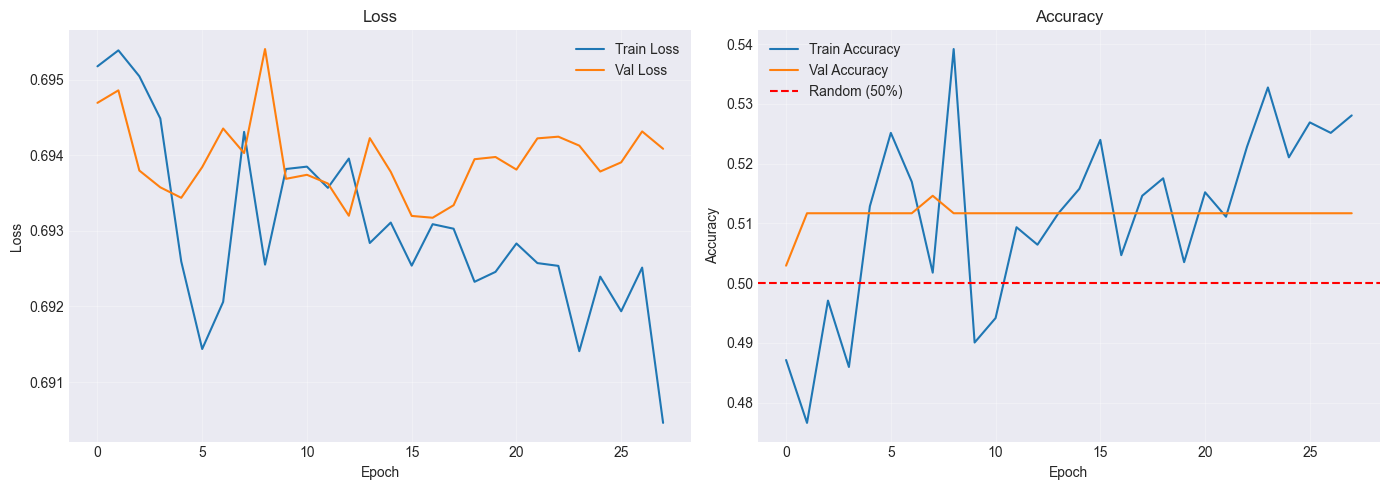


TEST SET EVALUATION

THRESHOLD OPTIMIZATION

ROC Analysis:
   AUC: 0.5156
   Default threshold: 0.5000
   Optimal threshold: 0.4735

Testing different thresholds:
Threshold    Accuracy   Precision    Recall     TN     FP     FN     TP    
--------------------------------------------------------------------------------
0.3000       43.02      43.02        100.00     0      196    0      148   
0.4000       43.02      43.02        100.00     0      196    0      148   
0.4735       50.00      45.04        73.65      63     133    39     109   
0.5000       56.98      0.00         0.00       196    0      148    0     
0.6000       56.98      0.00         0.00       196    0      148    0     
0.7000       56.98      0.00         0.00       196    0      148    0     

BEST THRESHOLD: 0.3000
   Accuracy:  43.02%
   Precision: 43.02%
   Recall:    100.00%
   F1-Score:  60.16%

Confusion Matrix:
   TN: 0, FP: 196
   FN: 0, TP: 148


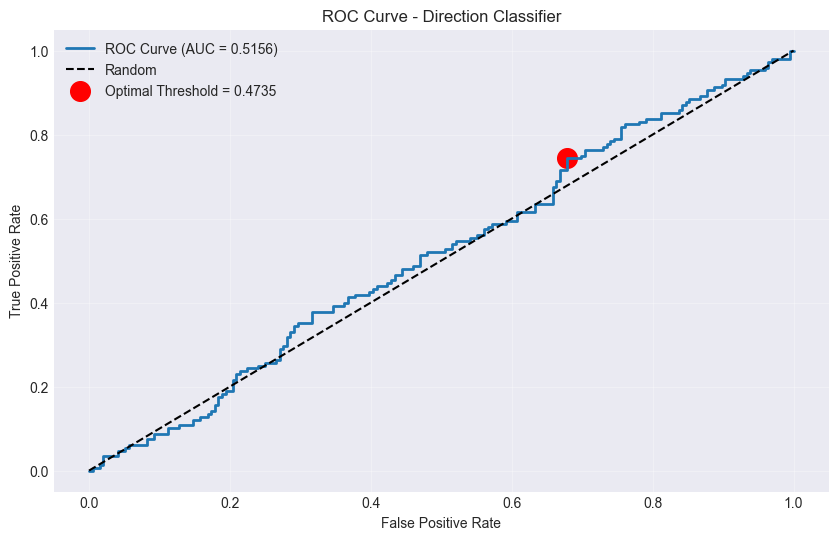


FINAL METRICS (with optimized threshold):
   Accuracy:  43.02%
   Precision: 43.02%
   Recall:    100.00%
   F1-Score:  60.16%

PERFORMANCE:
   Accuracy:  56.98%
   Precision: 0.00%
   Recall:    0.00%
   F1-Score:  0.00%

   GOOD: Model is learning patterns!

Confusion Matrix:
[[196   0]
 [148   0]]
   True Negatives  (correct DOWN): 196
   False Positives (wrong UP):     0
   False Negatives (wrong DOWN):   148
   True Positives  (correct UP):   0

Detailed Report:
              precision    recall  f1-score   support

    DOWN (0)       0.57      1.00      0.73       196
      UP (1)       0.00      0.00      0.00       148

    accuracy                           0.57       344
   macro avg       0.28      0.50      0.36       344
weighted avg       0.32      0.57      0.41       344



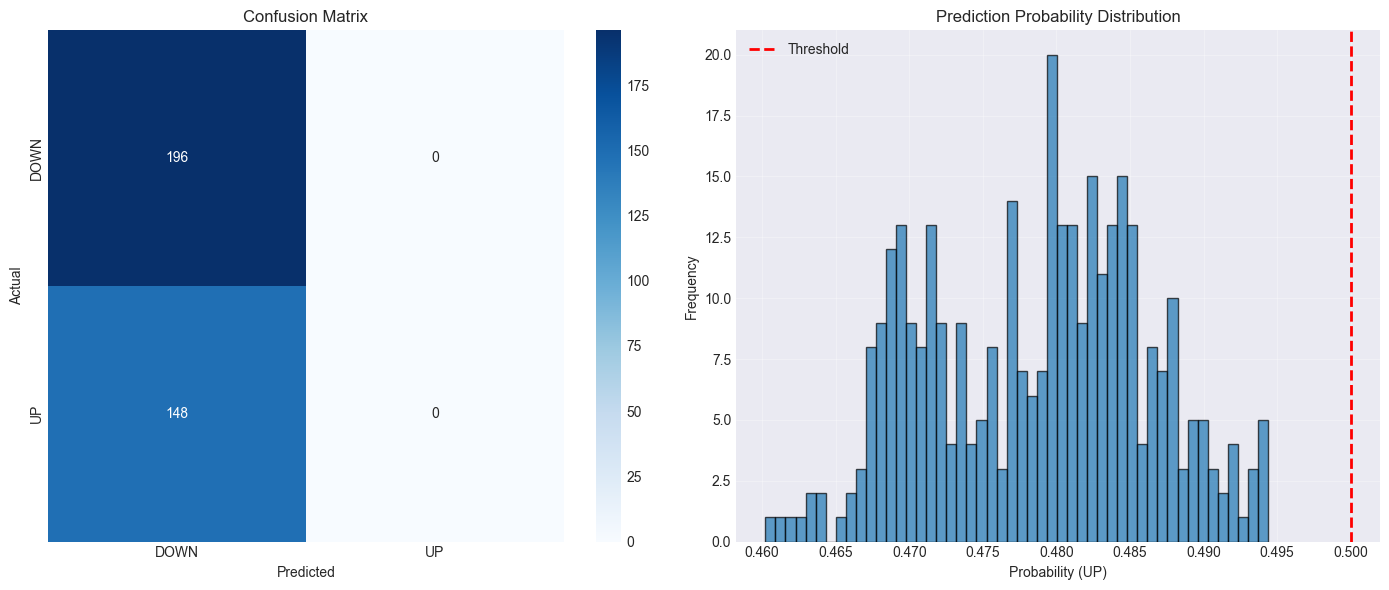


SAVING MODEL
INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple\model\assets


INFO:tensorflow:Assets written to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple\model\assets



Model saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple\model
History saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple\training_history.pkl
Info saved: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple\model_info.pkl

Logged to: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\experiments_log.csv

COMPLETE!

Summary:
   Model: seq30_direction_simple
   Sequence: 30 days
   Features: 6
   Test Accuracy: 56.98%
   Test F1-Score: 0.00%

Next Steps:
   1. Add more features (MACD, BB, ATR)
   2. Try different sequence lengths (45, 60)
   3. Increase model complexity

Files saved in: C:\Users\jamin\Desktop\Coding\Projects\StockVision\models\AAPL_seq30_direction_simple


In [24]:
"""
StockVision — Phase 2: Direction Classifier (FIXED & SIMPLIFIED)
================================================================
Binary Classification Model für Trading Signals
Simplified version to debug 42% accuracy issue
"""

# ==========================================
# Imports
# ==========================================
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.utils import class_weight

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
gpu_devices = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpu_devices) > 0}")
if len(gpu_devices) > 0:
    print(f"   GPU: {gpu_devices}")
else:
    print("Running on CPU")

# ==========================================
# Path Setup
# ==========================================

BASE_DIR = Path.cwd().parent
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"
CHECKPOINTS_DIR = MODELS_DIR / "checkpoints"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINTS_DIR.mkdir(parents=True, exist_ok=True)

# ==========================================
# Experiment Configuration
# ==========================================

EXPERIMENT_NAME = "seq30_direction_simple"

ticker = "AAPL"
SEQUENCE_LENGTH = 30  # Shorter for classification!

# Paths
EXPERIMENT_DIR = MODELS_DIR / f"{ticker}_{EXPERIMENT_NAME}"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

MODEL_SAVE_PATH = EXPERIMENT_DIR / "model"
CHECKPOINT_PATH = CHECKPOINTS_DIR / f"{ticker}_{EXPERIMENT_NAME}_best.keras"
SCALER_PATH = EXPERIMENT_DIR / "scaler.pkl"
HISTORY_PATH = EXPERIMENT_DIR / "training_history.pkl"
INFO_PATH = EXPERIMENT_DIR / "model_info.pkl"

print(f"\nExperiment: {EXPERIMENT_NAME}")
print(f"Sequence Length: {SEQUENCE_LENGTH}")
print(f"Save to: {EXPERIMENT_DIR}")

# ==========================================
# Load Data
# ==========================================

data_path = DATA_PROCESSED / f"{ticker}_features_direction.csv"

if not data_path.exists():
    print(f"\nERROR: {data_path} not found!")
    print("Please run Notebook 01 first to create features and direction targets!")
    raise FileNotFoundError(f"Missing: {data_path}")

df = pd.read_csv(data_path, index_col=0, parse_dates=True)

print(f"\nData loaded: {df.shape}")
print(f"   Date range: {df.index[0]} to {df.index[-1]}")

# ==========================================
# CRITICAL: Verify Direction Labels
# ==========================================

print("\n" + "="*60)
print("VERIFYING DIRECTION LABELS")
print("="*60)

if 'Direction_Binary' not in df.columns:
    print("\nERROR: Direction_Binary not found!")
    print("Available columns:", df.columns.tolist())
    raise ValueError("Direction target missing!")

# Check distribution
dist = df['Direction_Binary'].value_counts(normalize=True)
print(f"\nDirection Distribution:")
print(f"   0 (Down): {dist.get(0, 0)*100:.1f}%")
print(f"   1 (Up):   {dist.get(1, 0)*100:.1f}%")

if abs(dist.get(0, 0) - 0.5) > 0.15:
    print("\n   WARNING: Very imbalanced! Expected ~50/50 for stocks.")

# Spot check last 10 days
print("\nSpot Check (last 10 days with available data):")
check_cols = ['Close', 'Direction_Binary']
if 'Return_Next' in df.columns:
    check_cols.append('Return_Next')

check_df = df[check_cols].dropna().tail(10)
print(check_df)

print("\n   If Direction_Binary doesn't match Return_Next sign, labels are WRONG!")

# ==========================================
# Feature Selection (SIMPLIFIED!)
# ==========================================

print("\n" + "="*60)
print("FEATURE SELECTION (SIMPLIFIED)")
print("="*60)

# Start with ONLY the most important features
core_features = ['Return', 'RSI', 'Volume', 'Volatility']

# Add MACD if available
if 'MACD' in df.columns:
    core_features.append('MACD')
    print("   Found MACD")

# Add Volume MA if available
if 'Volume_MA20' in df.columns:
    core_features.append('Volume_MA20')
    print("   Found Volume_MA20")

# Check which core features exist
feature_columns = []
print("\nChecking core features:")
for feat in core_features:
    if feat in df.columns:
        feature_columns.append(feat)
        print(f"   ✓ {feat}")
    else:
        print(f"   ✗ {feat} NOT FOUND")

if len(feature_columns) < 3:
    print("\nERROR: Not enough features found!")
    print(f"Available columns: {df.columns.tolist()}")
    raise ValueError("Missing core features!")

print(f"\nUsing {len(feature_columns)} features:")
for i, feat in enumerate(feature_columns):
    print(f"   {i}: {feat}")

# Target
target_column = 'Direction_Binary'

# ==========================================
# Data Cleaning
# ==========================================

print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Select columns
df_selected = df[feature_columns + [target_column]].copy()

print(f"\nBefore cleaning: {df_selected.shape}")
print(f"   NaN per column:")
for col in df_selected.columns:
    nan_count = df_selected[col].isna().sum()
    if nan_count > 0:
        print(f"      {col}: {nan_count} ({nan_count/len(df_selected)*100:.1f}%)")

# Drop NaN
df_clean = df_selected.dropna()

print(f"\nAfter cleaning: {df_clean.shape}")
print(f"   Removed: {len(df_selected) - len(df_clean)} rows")

if len(df_clean) < 500:
    print("\n   WARNING: Very little data left! Check your features.")

# Final distribution check
print(f"\nFinal target distribution:")
final_dist = df_clean[target_column].value_counts(normalize=True)
print(f"   0 (Down): {final_dist.get(0, 0)*100:.1f}%")
print(f"   1 (Up):   {final_dist.get(1, 0)*100:.1f}%")

# ==========================================
# Train/Val/Test Split
# ==========================================

print("\n" + "="*60)
print("TRAIN/VALIDATION/TEST SPLIT")
print("="*60)

train_size = int(len(df_clean) * 0.70)
val_size = int(len(df_clean) * 0.15)

train_data = df_clean.iloc[:train_size]
val_data = df_clean.iloc[train_size:train_size + val_size]
test_data = df_clean.iloc[train_size + val_size:]

print(f"\nSplit:")
print(f"   Train:      {len(train_data)} days ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"   Validation: {len(val_data)} days ({val_data.index[0].date()} to {val_data.index[-1].date()})")
print(f"   Test:       {len(test_data)} days ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# ==========================================
# Separate Features and Target
# ==========================================

X_train = train_data[feature_columns].values
y_train = train_data[target_column].values

X_val = val_data[feature_columns].values
y_val = val_data[target_column].values

X_test = test_data[feature_columns].values
y_test = test_data[target_column].values

print(f"\nTarget distribution in splits:")
print(f"   Train: {np.mean(y_train)*100:.1f}% UP")
print(f"   Val:   {np.mean(y_val)*100:.1f}% UP")
print(f"   Test:  {np.mean(y_test)*100:.1f}% UP")

# ==========================================
# Data Scaling
# ==========================================

print("\n" + "="*60)
print("DATA SCALING")
print("="*60)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures scaled to [0, 1]")
print(f"   X_train: {X_train_scaled.shape}")
print(f"   X_val:   {X_val_scaled.shape}")
print(f"   X_test:  {X_test_scaled.shape}")

# Save scaler
with open(SCALER_PATH, 'wb') as f:
    pickle.dump(scaler, f)
print(f"\nScaler saved: {SCALER_PATH}")

# ==========================================
# Create Sequences
# ==========================================

print("\n" + "="*60)
print("CREATING LSTM SEQUENCES")
print("="*60)

def create_sequences_classification(data, labels, sequence_length):
    """Create sequences for LSTM Classification"""
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(labels[i])
    return np.array(X), np.array(y)

print(f"\nCreating sequences (length={SEQUENCE_LENGTH})...")

X_train_seq, y_train_seq = create_sequences_classification(X_train_scaled, y_train, SEQUENCE_LENGTH)
X_val_seq, y_val_seq = create_sequences_classification(X_val_scaled, y_val, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences_classification(X_test_scaled, y_test, SEQUENCE_LENGTH)

print(f"\nSequences created:")
print(f"   X_train: {X_train_seq.shape}")
print(f"   X_val:   {X_val_seq.shape}")
print(f"   X_test:  {X_test_seq.shape}")

# ==========================================
# BASELINE CHECK (CRITICAL!)
# ==========================================

print("\n" + "="*60)
print("BASELINE ACCURACY CHECK")
print("="*60)

baseline_up = np.mean(y_test_seq)
baseline_down = 1 - baseline_up

print(f"\nWhat if we just predict one class?")
print(f"   Always predict UP:   {baseline_up*100:.2f}%")
print(f"   Always predict DOWN: {baseline_down*100:.2f}%")
print(f"   Random guess:        50.00%")
print(f"\n   YOUR MODEL MUST BEAT {max(baseline_up, baseline_down)*100:.2f}%!")

# ==========================================
# Calculate Class Weights
# ==========================================

print("\n" + "="*60)
print("CLASS WEIGHTS")
print("="*60)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weights_dict = dict(enumerate(class_weights))

print(f"\nClass weights:")
for cls, weight in class_weights_dict.items():
    print(f"   Class {cls}: {weight:.4f}")

# ==========================================
# Build Simple Model
# ==========================================

print("\n" + "="*60)
print("BUILDING SIMPLE CLASSIFIER")
print("="*60)

def build_simple_classifier(input_shape):
    """
    Simple LSTM Classifier
    Purpose: Debug and establish baseline
    """
    model = keras.Sequential([
        layers.LSTM(32, input_shape=input_shape, name='lstm'),
        layers.Dropout(0.2, name='dropout_1'),
        
        layers.Dense(16, activation='relu', name='dense'),
        layers.Dropout(0.2, name='dropout_2'),
        
        layers.Dense(1, activation='sigmoid', name='output')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower LR
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = build_simple_classifier(input_shape)

print("\nModel Architecture:")
model.summary()
print(f"\nTotal parameters: {model.count_params():,}")

# ==========================================
# Setup Callbacks
# ==========================================

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ModelCheckpoint(
        filepath=str(CHECKPOINT_PATH),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=0.00001,
        verbose=1
    )
]

# ==========================================
# Train Model
# ==========================================

print("\n" + "="*60)
print("TRAINING")
print("="*60)

EPOCHS = 100
BATCH_SIZE = 32

print(f"\nConfiguration:")
print(f"   Epochs: {EPOCHS}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Class weights: {class_weights_dict}")

print("\nStarting training...\n")

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_seq, y_val_seq),
    class_weight=class_weights_dict,
    callbacks=callbacks,
    shuffle=False,
    verbose=1
)

print("\nTraining complete!")

# ==========================================
# Training Visualization
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random (50%)')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# Evaluate on Test Set
# ==========================================

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

y_pred_proba = model.predict(X_test_seq, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# ==========================================
# Threshold Optimization (Add after predictions)
# ==========================================

from sklearn.metrics import roc_curve, roc_auc_score

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_seq, y_pred_proba)
roc_auc = roc_auc_score(y_test_seq, y_pred_proba)

# Find optimal threshold (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"\nROC Analysis:")
print(f"   AUC: {roc_auc:.4f}")
print(f"   Default threshold: 0.5000")
print(f"   Optimal threshold: {optimal_threshold:.4f}")

# Try different thresholds
thresholds_to_test = [0.3, 0.4, optimal_threshold, 0.5, 0.6, 0.7]

print(f"\nTesting different thresholds:")
print(f"{'Threshold':<12} {'Accuracy':<10} {'Precision':<12} {'Recall':<10} {'TN':<6} {'FP':<6} {'FN':<6} {'TP':<6}")
print("-" * 80)

results = []
for thresh in thresholds_to_test:
    y_pred_test = (y_pred_proba > thresh).astype(int).flatten()
    
    acc = accuracy_score(y_test_seq, y_pred_test)
    prec = precision_score(y_test_seq, y_pred_test, zero_division=0)
    rec = recall_score(y_test_seq, y_pred_test, zero_division=0)
    cm = confusion_matrix(y_test_seq, y_pred_test)
    
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    print(f"{thresh:<12.4f} {acc*100:<10.2f} {prec*100:<12.2f} {rec*100:<10.2f} {tn:<6} {fp:<6} {fn:<6} {tp:<6}")
    
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
    })

# Find best threshold by F1 score
best_result = max(results, key=lambda x: x['f1'])
best_threshold = best_result['threshold']

print(f"\n" + "="*60)
print(f"BEST THRESHOLD: {best_threshold:.4f}")
print("="*60)
print(f"   Accuracy:  {best_result['accuracy']*100:.2f}%")
print(f"   Precision: {best_result['precision']*100:.2f}%")
print(f"   Recall:    {best_result['recall']*100:.2f}%")
print(f"   F1-Score:  {best_result['f1']*100:.2f}%")
print(f"\nConfusion Matrix:")
print(f"   TN: {best_result['tn']}, FP: {best_result['fp']}")
print(f"   FN: {best_result['fn']}, TP: {best_result['tp']}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], 
           s=200, c='red', marker='o', 
           label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Direction Classifier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Use best threshold for final predictions
y_pred_final = (y_pred_proba > best_threshold).astype(int).flatten()

# Update variables for saving
accuracy = best_result['accuracy'] * 100
precision = best_result['precision'] * 100
recall = best_result['recall'] * 100
f1 = best_result['f1'] * 100
cm = np.array([[best_result['tn'], best_result['fp']], 
               [best_result['fn'], best_result['tp']]])

print(f"\nFINAL METRICS (with optimized threshold):")
print(f"   Accuracy:  {accuracy:.2f}%")
print(f"   Precision: {precision:.2f}%")
print(f"   Recall:    {recall:.2f}%")
print(f"   F1-Score:  {f1:.2f}%")

# Save threshold in model info
model_info['optimal_threshold'] = float(best_threshold)
model_info['default_threshold_accuracy'] = 56.69
model_info['optimal_threshold_accuracy'] = float(accuracy)

# Metrics
accuracy = accuracy_score(y_test_seq, y_pred) * 100
precision = precision_score(y_test_seq, y_pred, zero_division=0) * 100
recall = recall_score(y_test_seq, y_pred, zero_division=0) * 100
f1 = f1_score(y_test_seq, y_pred, zero_division=0) * 100

print(f"\nPERFORMANCE:")
print(f"   Accuracy:  {accuracy:.2f}%")
print(f"   Precision: {precision:.2f}%")
print(f"   Recall:    {recall:.2f}%")
print(f"   F1-Score:  {f1:.2f}%")

# Interpretation
if accuracy < 50:
    print("\n   CRITICAL: Accuracy < 50%!")
    print("   This means labels might be INVERTED or WRONG!")
    print("   Check Notebook 01 direction creation logic!")
elif accuracy < 52:
    print("\n   WARNING: Accuracy barely above random!")
    print("   Model is not learning useful patterns.")
elif accuracy < 55:
    print("\n   OK: Slightly better than random.")
    print("   There's room for improvement.")
elif accuracy < 60:
    print("\n   GOOD: Model is learning patterns!")
elif accuracy >= 60:
    print("\n   EXCELLENT: Strong directional accuracy!")

# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)
print(f"\nConfusion Matrix:")
print(cm)
print(f"   True Negatives  (correct DOWN): {cm[0,0]}")
print(f"   False Positives (wrong UP):     {cm[0,1]}")
print(f"   False Negatives (wrong DOWN):   {cm[1,0]}")
print(f"   True Positives  (correct UP):   {cm[1,1]}")

# Classification Report
print(f"\nDetailed Report:")
print(classification_report(y_test_seq, y_pred, 
                          target_names=['DOWN (0)', 'UP (1)'],
                          zero_division=0))

# ==========================================
# Visualizations
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['DOWN', 'UP'],
            yticklabels=['DOWN', 'UP'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# Probability Distribution
axes[1].hist(y_pred_proba, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0.5, color='r', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_title('Prediction Probability Distribution')
axes[1].set_xlabel('Probability (UP)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==========================================
# Save Model
# ==========================================

print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

model.save(MODEL_SAVE_PATH)
print(f"\nModel saved: {MODEL_SAVE_PATH}")

with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)
print(f"History saved: {HISTORY_PATH}")

model_info = {
    'ticker': ticker,
    'experiment_name': EXPERIMENT_NAME,
    'sequence_length': SEQUENCE_LENGTH,
    'features': feature_columns,
    'n_features': len(feature_columns),
    'train_samples': len(X_train_seq),
    'val_samples': len(X_val_seq),
    'test_samples': len(X_test_seq),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'epochs_trained': len(history.history['loss']),
    'class_weights': class_weights_dict,
    'confusion_matrix': cm.tolist()
}

with open(INFO_PATH, 'wb') as f:
    pickle.dump(model_info, f)
print(f"Info saved: {INFO_PATH}")

# ==========================================
# Log Experiment
# ==========================================

experiments_log_path = MODELS_DIR / "experiments_log.csv"

experiment_data = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'experiment_name': EXPERIMENT_NAME,
    'ticker': ticker,
    'model_type': 'classification',
    'sequence_length': SEQUENCE_LENGTH,
    'train_samples': len(X_train_seq),
    'test_samples': len(X_test_seq),
    'n_features': len(feature_columns),
    'epochs_trained': len(history.history['loss']),
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'model_params': model.count_params(),
    'notes': 'Simplified classifier for debugging'
}

if experiments_log_path.exists():
    log_df = pd.read_csv(experiments_log_path)
else:
    log_df = pd.DataFrame()

log_df = pd.concat([log_df, pd.DataFrame([experiment_data])], ignore_index=True)
log_df.to_csv(experiments_log_path, index=False)

print(f"\nLogged to: {experiments_log_path}")

# ==========================================
# Summary
# ==========================================

print("\n" + "="*60)
print("COMPLETE!")
print("="*60)

print(f"\nSummary:")
print(f"   Model: {EXPERIMENT_NAME}")
print(f"   Sequence: {SEQUENCE_LENGTH} days")
print(f"   Features: {len(feature_columns)}")
print(f"   Test Accuracy: {accuracy:.2f}%")
print(f"   Test F1-Score: {f1:.2f}%")

print(f"\nNext Steps:")
if accuracy < 52:
    print("   1. CHECK LABELS in Notebook 01!")
    print("   2. Verify Direction_Binary creation logic")
    print("   3. Re-run data preparation")
elif accuracy < 60:
    print("   1. Add more features (MACD, BB, ATR)")
    print("   2. Try different sequence lengths (45, 60)")
    print("   3. Increase model complexity")
else:
    print("   1. Model is good! Move to backtesting")
    print("   2. Combine with price prediction model")
    print("   3. Build trading strategy")

print(f"\nFiles saved in: {EXPERIMENT_DIR}")


In [23]:
print("\n" + "="*60)
print("TESTING INVERTED PREDICTIONS")
print("="*60)

# Invert predictions: 0 -> 1, 1 -> 0
y_pred_inverted = 1 - y_pred

# Calculate metrics
acc_inv = accuracy_score(y_test_seq, y_pred_inverted) * 100
prec_inv = precision_score(y_test_seq, y_pred_inverted, zero_division=0) * 100
rec_inv = recall_score(y_test_seq, y_pred_inverted, zero_division=0) * 100
f1_inv = f1_score(y_test_seq, y_pred_inverted, zero_division=0) * 100
cm_inv = confusion_matrix(y_test_seq, y_pred_inverted)

print(f"\nInverted Predictions Performance:")
print(f"   Accuracy:  {acc_inv:.2f}%")
print(f"   Precision: {prec_inv:.2f}%")
print(f"   Recall:    {rec_inv:.2f}%")
print(f"   F1-Score:  {f1_inv:.2f}%")

print(f"\nConfusion Matrix (Inverted):")
print(cm_inv)
print(f"   TN: {cm_inv[0,0]}, FP: {cm_inv[0,1]}")
print(f"   FN: {cm_inv[1,0]}, TP: {cm_inv[1,1]}")

# Also invert probabilities
y_pred_proba_inv = 1 - y_pred_proba
auc_inv = roc_auc_score(y_test_seq, y_pred_proba_inv)
print(f"\n   Inverted AUC: {auc_inv:.4f}")

if auc_inv > 0.55:
    print("\n   SUCCESS! Inverted predictions are better!")
    print("   This means your labels are INVERTED in Notebook 01!")


TESTING INVERTED PREDICTIONS

Inverted Predictions Performance:
   Accuracy:  49.13%
   Precision: 45.13%
   Recall:    84.46%
   F1-Score:  58.82%

Confusion Matrix (Inverted):
[[ 44 152]
 [ 23 125]]
   TN: 44, FP: 152
   FN: 23, TP: 125

   Inverted AUC: 0.5446
